In [1]:
import os
import h5py

import numpy as np
from scipy.stats import iqr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec


In [2]:
basedir = '../data'

In [3]:
bkgrd_set = {
    # shift 2
    1: (71, 115), # injection
    # shift 3
    2: (122, 126), # beamline
    3: (127, 198), # injection
    4: (214, 280), # injection after detector shift
    # shift 4
    5: (293, 296), # beamline
    6: (297, 320), # injection
    #7: (354, 449),
    # shift 5
    7: (481, 513), # injection
}


In [4]:
bg = dict()
print("      Nfrm  median(v)     max(v)  median(s)     max(s)")
for s in bkgrd_set.keys():
    r0, rN = bkgrd_set[s]
    fn = os.path.join(basedir, "bg/bgcomb-r{:04d}-r{:04d}.h5".format(r0,rN))
    f = h5py.File(fn, 'r')

    a=type('BGDATA', (), {})
    a.width = f['data/width'][()]
    a.ri = f['data/xy'][:]
    a.r0 = f['data/center'][:]

    a.vi = f['data/val'][:]
    a.si = f['data/sig'][:]
    a.ei = f['data/eps'][:]
    a.ni = f['data/n'][:]


    a.qr = f['rdf/q'][:]
    a.vr = f['rdf/val'][:]
    a.nr = f['rdf/n'][:]
    a.sr = f['rdf/sig'][:]

    f.close()

    bg[s] = a
    
    print("{:10.0f} {:10.3g} {:10.3g} {:10.3g} {:10.3g} {:10.3g} {:10.3g}".format(np.median(a.ni), 
            np.median(a.vi), np.max(a.vi), np.median(a.si), np.max(a.si), np.median(a.ei), np.max(a.ei)))

      Nfrm  median(v)     max(v)  median(s)     max(s)
    633898    0.00131        1.2      0.429       2.87   0.000181    0.00226
     34000    0.00166      0.332       1.29       11.3   0.000779     0.0102
   1604349    0.00251      0.473       1.07       4.19   0.000113     0.0014
   1991148  -0.000461       13.4      0.256       19.8   0.000102    0.00126
    119727    0.00162       1.11      0.168       1.63   0.000419    0.00375
    535947   0.000834       2.55      0.171       9.22   0.000197    0.00178
    351078   -0.00084       5.38      0.673       14.5    0.00025    0.00307


In [5]:
def show_one_bg(a, ax, mx, cax=None, tk=None, w=None):
    cm = plt.cm.get_cmap('terrain_r')
    cm.set_bad((.98,.98,.98))

    if w is None:
        w = a.width
    idx = np.logical_and(np.abs(a.ri[:,0]) <= w, np.abs(a.ri[:,1]) <= w )

    i = (a.ri[idx,0] + w).astype(int)
    j = (a.ri[idx,1] + w).astype(int)
    n = 2*w+1

    img = np.zeros([n, n], dtype=float)
    img[:] =float('nan')
    img[j,i] = a.vi[idx]


    iq = .05
    ss = ((np.log(mx) - np.log(iq)) / (iq))/450

    nrm=SymLogNorm(iq, ss, -iq, mx)
    #nrm=LogNorm()

    im = ax.matshow(img, cmap=cm, norm=nrm, vmax=mx)

    if cax:
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("top", size="5%", pad=0.2)

        plt.colorbar(im, cax=cax, orientation='horizontal', format='%.3g', ticks=tk)

    ax.set_axis_off()


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1122: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


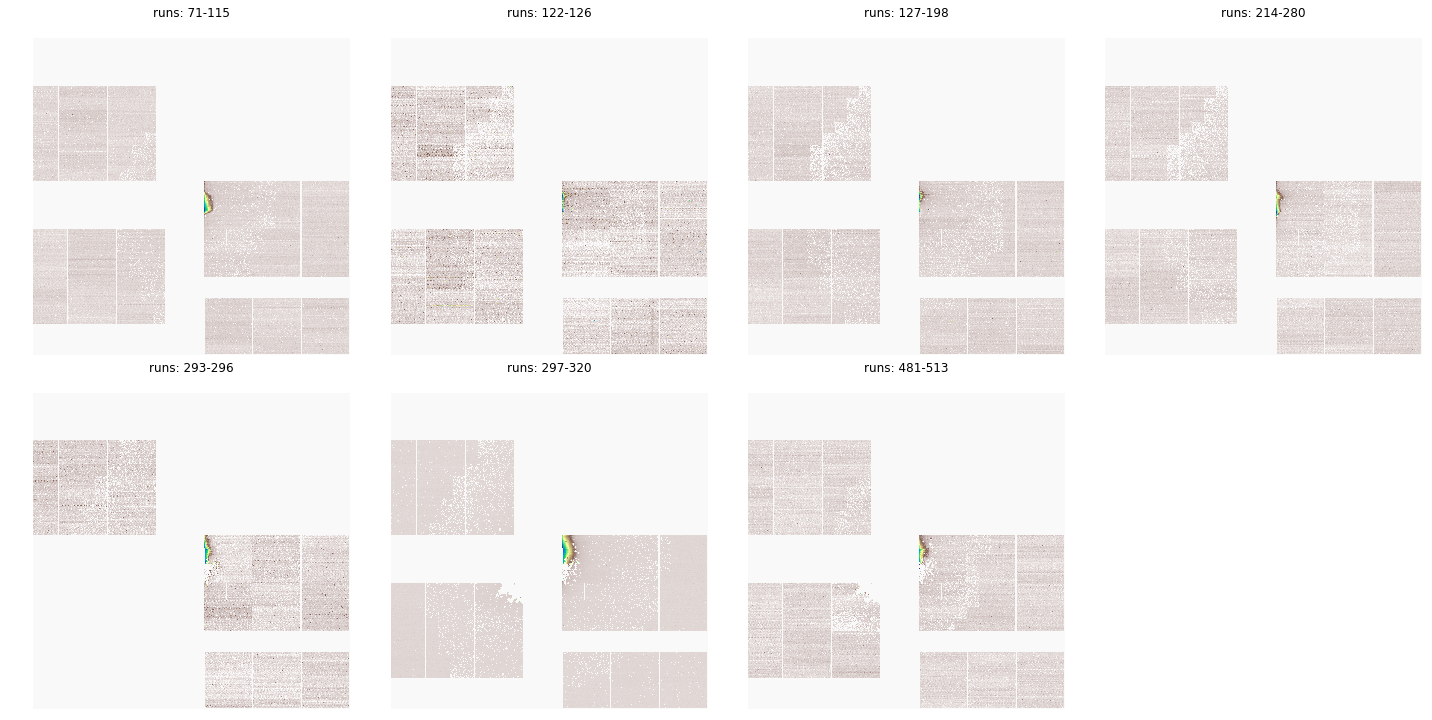

In [6]:
gs = gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(20,10))
i = 0
for s in bkgrd_set.keys():
    a = bg[s]
    ax = plt.subplot(gs[i])
    ax.set_title('runs: {}-{}'.format(*bkgrd_set[s]))
    show_one_bg(bg[s], ax, a.vi.max())
    i += 1
plt.tight_layout()
plt.savefig('fig1.png', dpi=300)
plt.show()

In [7]:
def show_two_bg(a, b, mx, lb, tk=None, w=None):
    gs = gridspec.GridSpec(4, 1,
                           height_ratios=[0.5, 10,10, 4]
                           )
    gs.update(hspace=0.05)

    fig = plt.figure(figsize=[6, 16])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    plt.tight_layout()

    show_one_bg(a, ax2, mx, ax1, tk, w)
    ax2.text(-15,10, lb[0] + ')', fontsize=16)
    show_one_bg(b, ax3, mx, None, w=w)
    ax3.text(-15,10, lb[1] + ')', fontsize=16)

    ax1.tick_params(bottom=False, top=True, labelbottom=False, labeltop=True)

    ax4.plot(a.qr, a.vr, linewidth=2)
    ax4.plot(b.qr, b.vr, linewidth=2)
    ax4.set_yscale('symlog', linthreshy=0.05)
    ax4.set_xlabel('$q, \mathrm{\AA}^{-1}$')
    ax4.set_ylabel('$I, \mathrm{photon}/\mathrm{\AA}^2$')
    ax4.text(-0.001, mx, lb[2] + ')', fontsize=16)


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1122: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


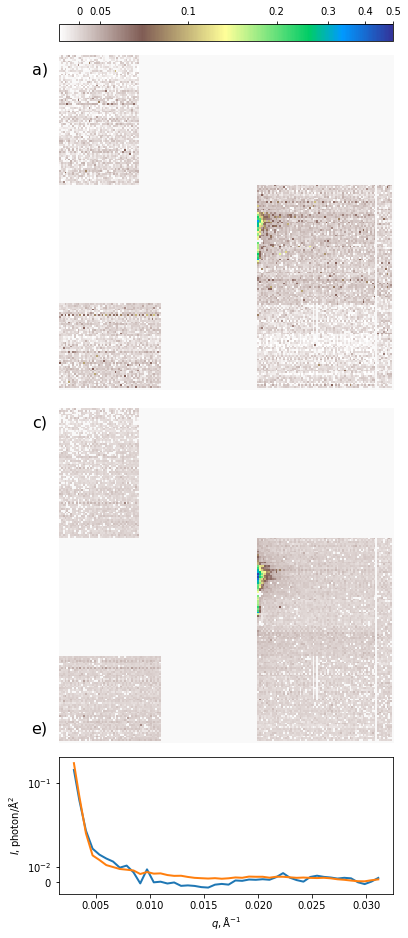

In [8]:
show_two_bg(bg[2], bg[3], 0.5, ['a', 'c', 'e'], [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 90)
plt.savefig('fig2a.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1122: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


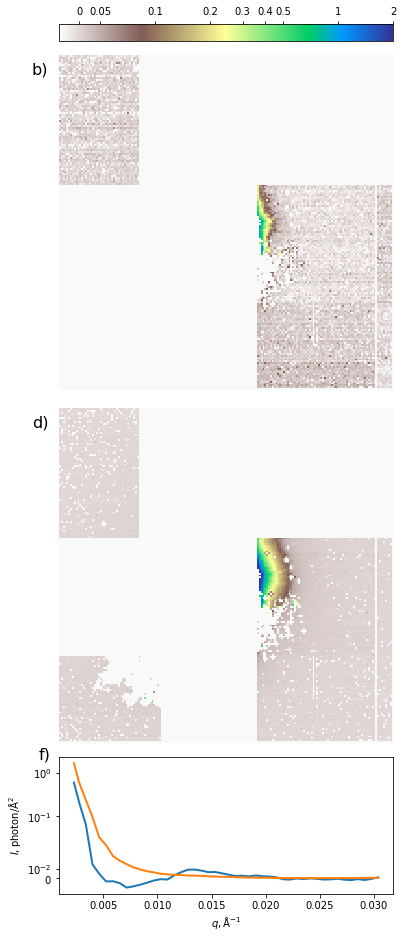

In [9]:

show_two_bg(bg[5], bg[6], 2, ['b', 'd', 'f'], [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2], 90)
plt.savefig('fig2b.png', dpi=300)
plt.show()